In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

%cd ..

c:\Users\javie\Documents\magister\propagacion-incendios


C:\Users\javie\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Funciones

In [2]:
def cambiar_fecha(df):
    df['acq_datetime'] = pd.to_datetime(df['acq_date'].astype(str) + ' ' + df['acq_time'].astype(str).str.zfill(4), format='%Y-%m-%d %H%M')
    return df


def plot_buffer_viirs(subset):

    # proyectar a metros
    subset2_m = subset.to_crs(epsg=3857)

    # buffer de 187.5 metros
    buffer_m = subset2_m.geometry.buffer(187.5)

    # convertir el buffer de vuelta a lat/lon
    buffer_wgs84 = gpd.GeoSeries(buffer_m, crs=3857).to_crs(epsg=4326)

    subset['pixel_area'] = buffer_wgs84


    ## plot
    pixel_map = subset.set_geometry('pixel_area').explore(
        column='acq_datetime',
        cmap='plasma',
        legend=True,
        tooltip='acq_datetime'
    )

    return subset.explore(
        m=pixel_map,
        color='black',
        marker_kwds={'radius': 2}
    )


### Zonas de incendios con FIRMS

In [3]:
path_landsat = r'data\EEUU\URT\API\LANDSAT\LANDSAT_2004.shp'
path_Modis = r'data\EEUU\URT\API\modis\modis_2004.shp'
path_NOAA20 = r'data\EEUU\URT\API\NOAA20\NOAA20_2004.shp'   
path_NOAA21 = r'data\EEUU\URT\API\NOAA21\NOAA21_2004.shp'  
path_sv = r'data\EEUU\URT\API\SUOMI\SUOMI_2004.shp'  

SUOMI = cambiar_fecha(gpd.read_file(path_sv))
j1 = cambiar_fecha(gpd.read_file(path_NOAA20))
j2 = cambiar_fecha(gpd.read_file(path_NOAA21))
modis = cambiar_fecha(gpd.read_file(path_Modis))

todos =  pd.concat([SUOMI, j1, j2, modis]).reset_index(drop = True)

In [4]:
areas = {
    #"carolina_norte":box(-82.25418, 35.72955, -82.09592, 35.90865),
    "picker_flats": box(-94.81305, 35.91905, -94.74988, 35.96423),
    "area2": box(-94.90265, 36.26983, -94.87749, 36.30902),
    "haoe_lead": box(-83.97421, 35.34632, -83.91338, 35.39466),
    "bee_rock_creek": box(-82.17802, 35.77566, -82.06976, 35.85195)
}

In [5]:
areas_buffer = {}
for area_name, area_box in areas.items():
    print('revisando area', area_name)
    subset = todos[todos.geometry.within(area_box)]
    
    fire_bounds = subset.total_bounds  
    buffer_deg = 0.009 * 2  ## 3km
    
    grilla_bounds = (fire_bounds[0] - buffer_deg, fire_bounds[1] - buffer_deg,
                     fire_bounds[2] + buffer_deg, fire_bounds[3] + buffer_deg 
                     )
    grilla_bounds = box(*grilla_bounds)
    areas_buffer[area_name] = grilla_bounds

revisando area picker_flats
revisando area area2
revisando area haoe_lead
revisando area bee_rock_creek


In [6]:
subset = todos[todos.geometry.within(areas_buffer['bee_rock_creek'])]
plot_buffer_viirs(subset)

c:\Users\javie\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
todos['zona'] = None  # inicializamos la columna

for area_name, area_box in areas_buffer.items():
    print(area_name)
    mask = todos.geometry.within(areas_buffer[area_name])
    todos.loc[mask, 'zona'] = area_name

todos_filtrado = todos[~todos['zona'].isnull()]

picker_flats
area2
haoe_lead
bee_rock_creek


In [8]:
todos_filtrado.zona.value_counts()

zona
haoe_lead         187
bee_rock_creek     97
area2              66
picker_flats       52
Name: count, dtype: int64

In [9]:
todos_filtrado.to_file("data/procesado/zonas_incendios/puntos_FIRMS_con_zonas.geojson", driver="GeoJSON")

In [10]:
# Convertimos el diccionario a una lista de tuplas
buffer_data = [(name, geom) for name, geom in areas_buffer.items()]

# Lo convertimos en un GeoDataFrame
gdf_buffers = gpd.GeoDataFrame(buffer_data, columns=['zona', 'geometry'], crs='EPSG:4326')  # usa tu CRS

gdf_buffers.to_file("data/procesado/zonas_incendios/areas_buffer.geojson", driver="GeoJSON")

### Identificación de zonas con HealPix

In [ ]:
from rhealpixdggs.dggs import *
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

In [12]:
rdggs = RHEALPixDGGS()

nw = (areas_buffer['bee_rock_creek'].bounds[0], areas_buffer['bee_rock_creek'].bounds[3])
se = (areas_buffer['bee_rock_creek'].bounds[2], areas_buffer['bee_rock_creek'].bounds[1])
Nivel = 10

polygons = []
codigo = []
cells = rdggs.cells_from_region(Nivel, nw, se, plane=False)
for row in cells:
    for cell in row:
        coordenadas = []
        celda = str(cell)
        primero = [celda[0]]+ [int(c) for c in celda[1:]]
        c = rdggs.cell(primero)
        for d in c.boundary(n=2, plane=False):
            # coord = tuple(my_round(val, 14) for val in d)
            coord = tuple(round(val, 14) for val in d)            
            coordenadas.append(coord)
        if coordenadas[0] != coordenadas[-1]:
            coordenadas.append(coordenadas[0])
        codigo.append(celda)
        polygon = Polygon(coordenadas)
        polygons.append(polygon)

gdf_healpix = gpd.GeoDataFrame(crs="EPSG:4326", geometry=polygons)
gdf_healpix['Codigo'] = codigo

In [14]:
puntos_incendio = todos_filtrado[todos_filtrado['zona'] == 'bee_rock_creek']

In [15]:
## transformación de puntos de incendios a cuadrados:

# 1. Reproyectamos a metros (UTM zona correspondiente, o USA: EPSG:5070 es bueno para zonas del este)
gdf_m = puntos_incendio.to_crs("EPSG:5070")  # O usa la zona UTM correspondiente

# 2. Creamos buffers rectangulares (no circular) de 375/2 m
def make_pixel_square(point, size=375):
    half = size / 2
    return box(point.x - half, point.y - half, point.x + half, point.y + half)

gdf_m['geometry'] = gdf_m.geometry.apply(lambda p: make_pixel_square(p, size=375))

# 3. Volvemos a lat/lon si querés plotear con base en EPSG:4326
gdf_pixel_polys = gdf_m.to_crs("EPSG:4326")

In [18]:
gdf_pixel_polys = gdf_pixel_polys[gdf_pixel_polys['instrument'] == 'VIIRS']

In [26]:
gdf_pixel_polys['timestamp_num'] = pd.to_datetime(gdf_pixel_polys['acq_datetime']).view("int64") / 1e9

C:\Users\javie\AppData\Local\Temp\ipykernel_7164\3837811007.py:1: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  gdf_pixel_polys['timestamp_num'] = pd.to_datetime(gdf_pixel_polys['acq_datetime']).view("int64") / 1e9
c:\Users\javie\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


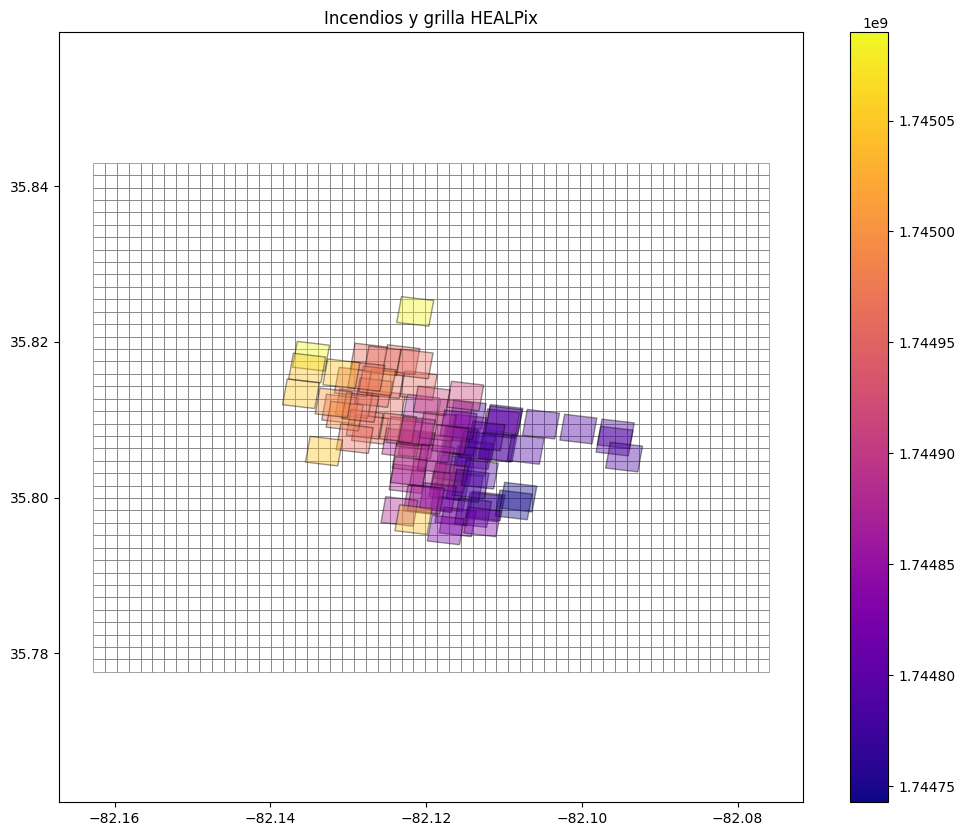

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

# grilla de fondo
gdf_healpix.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5, label='Grilla HEALPix')

# pixeles de incendio
gdf_pixel_polys.plot(ax=ax, column = 'timestamp_num', cmap ='plasma',edgecolor='black', alpha=0.4, legend=True)

ax.set_title("Incendios y grilla HEALPix")
plt.axis('equal')
plt.show()